In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
dataset_zip_path = "/content/drive/MyDrive/archive (4).zip"
extract_to = "/content/dataset"


In [20]:
# 2) Extract if not already extracted
if not os.path.exists(extract_to):
    print("Extracting zip...")
    with ZipFile(dataset_zip_path, 'r') as z:
        z.extractall(extract_to)
    print("Done extracting to", extract_to)
else:
    print("Dataset folder already exists:", extract_to)

Dataset folder already exists: /content/dataset


In [22]:
# 3) Set train / val paths (adjust if different
train_path = os.path.join(extract_to, "train")
val_path   = os.path.join(extract_to, "val")

print("\nPaths:")
print("TRAIN:", train_path)
print("VAL  :", val_path)



Paths:
TRAIN: /content/dataset/train
VAL  : /content/dataset/val


In [23]:
# 4) --- YAHAN COUNT: cat and dog images count ---
def safe_count(dir_path, subfolder):
    p = os.path.join(dir_path, subfolder)
    if os.path.exists(p):
        return len([f for f in os.listdir(p) if os.path.isfile(os.path.join(p,f))])
    else:
        return None

train_cat = safe_count(train_path, 'cat')
train_dog = safe_count(train_path, 'dog')
val_cat   = safe_count(val_path, 'cat')
val_dog   = safe_count(val_path, 'dog')

print("\n--- Image counts (check here) ---")
print("Train - Cats:", train_cat)
print("Train - Dogs:", train_dog)
print("Val   - Cats:", val_cat)
print("Val   - Dogs:", val_dog)
print("----------------------------------\n")


--- Image counts (check here) ---
Train - Cats: 95
Train - Dogs: 180
Val   - Cats: 24
Val   - Dogs: 46
----------------------------------



In [ ]:
# If any of the counts is None, path names might be different — print directory listing
if train_cat is None or train_dog is None:
    print("Train folder contents:", os.listdir(train_path) if os.path.exists(train_path) else "TRAIN folder not found")
if val_cat is None or val_dog is None:
    print("Val folder contents:", os.listdir(val_path) if os.path.exists(val_path) else "VAL folder not found")


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)
val_gen = val_datagen.flow_from_directory(
    val_path,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

print("\nClass indices (train):", train_gen.class_indices)


Found 275 images belonging to 2 classes.
Found 70 images belonging to 2 classes.

Class indices (train): {'cat': 0, 'dog': 1}


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(150,150,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,401,921 (20.61 MB)

 Trainable params: 5,401,921 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Generate class weights based on your training data counts
class_weights = {0: 180/95, 1: 1.0}  # (0 = cat, 1 = dog)
print("Class Weights:", class_weights)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop],
    class_weight=class_weights
)

Class Weights: {0: 1.894736842105263, 1: 1.0}
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6424 - loss: 0.8839 - val_accuracy: 0.6571 - val_loss: 0.6498
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6683 - loss: 0.8513 - val_accuracy: 0.5429 - val_loss: 0.7022
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5683 - loss: 0.8821 - val_accuracy: 0.4000 - val_loss: 0.7406
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5728 - loss: 0.8718 - val_accuracy: 0.6857 - val_loss: 0.6699


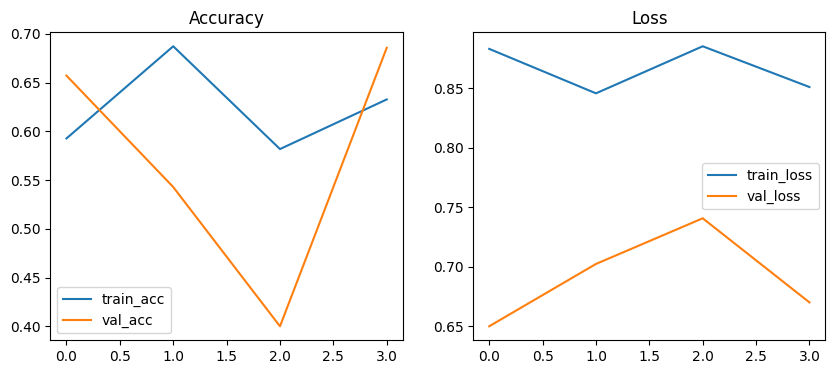

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()

In [ ]:
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print("Validation loss:", val_loss, "Validation accuracy:", val_acc)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.6723 - loss: 0.6257
Validation loss: 0.6497842669487 Validation accuracy: 0.6571428775787354


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image


In [ ]:
print("\nUpload a test image now (cat or dog):")
uploaded = files.upload()


Upload a test image now (cat or dog):


Saving download (1).jpg to download (1) (2).jpg


In [ ]:
if len(uploaded) > 0:
    img_name = list(uploaded.keys())[0]
    img_path = img_name
    img = image.load_img(img_path, target_size=(150,150))
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    pred = model.predict(arr)[0][0]
    print("Prediction probability (0->cat, 1->dog):", pred)
    if pred > 0.5:
        print("🐶 Predicted: Dog (confidence {:.2f})".format(pred))
    else:
        print("🐱 Predicted: Cat (confidence {:.2f})".format(1-pred))
else:
    print("No image uploaded.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Prediction probability (0->cat, 1->dog): 0.4758846
🐱 Predicted: Cat (confidence 0.52)


In [ ]:
print("\nUpload a test image now (cat or dog):")
uploaded = files.upload()


Upload a test image now (cat or dog):


Saving download.jpg to download.jpg


In [ ]:
if len(uploaded) > 0:
    img_name = list(uploaded.keys())[0]
    img_path = img_name
    img = image.load_img(img_path, target_size=(150,150))
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    pred = model.predict(arr)[0][0]
    print("Prediction probability (0->cat, 1->dog):", pred)
    if pred > 0.5:
        print("🐶 Predicted: Dog (confidence {:.2f})".format(pred))
    else:
        print("🐱 Predicted: Cat (confidence {:.2f})".format(1-pred))
else:
    print("No image uploaded.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction probability (0->cat, 1->dog): 0.6542653
🐶 Predicted: Dog (confidence 0.65)


In [ ]:
print("\nUpload a test image now (cat or dog):")
uploaded = files.upload()


Upload a test image now (cat or dog):


Saving download (3).jpg to download (3) (3).jpg


In [ ]:
if len(uploaded) > 0:
    img_name = list(uploaded.keys())[0]
    img_path = img_name
    img = image.load_img(img_path, target_size=(150,150))
    arr = image.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    pred = model.predict(arr)[0][0]
    print("Prediction probability (0->cat, 1->dog):", pred)
    if pred > 0.5:
        print("🐶 Predicted: Dog (confidence {:.2f})".format(pred))
    else:
        print("🐱 Predicted: Cat (confidence {:.2f})".format(1-pred))
else:
    print("No image uploaded.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction probability (0->cat, 1->dog): 0.42875448
🐱 Predicted: Cat (confidence 0.57)


In [ ]:
model.save('my_cnn_model.h5')

